In [1]:
BATCH_SIZE = 128
IMAGE_SIZE = [224, 224, 3]
NUM_CLASSES = 7

colorNames = ["black", "gold", "green", "pink", "silver", "wood", "yellow"]

In [2]:
import os
import glob
import json
import numpy as np
import tensorflow as tf
import cv2
import math
from transform import order_points, poly2view_angle
from tqdm import tqdm

## Avoid to use all GPU(s)VRAM
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: tf.config.experimental.set_memory_growth(gpu, True)

# Converting the values into features
def _int64_feature(value):  # _int64 is used for numeric values
    return tf.train.Feature(int64_list=tf.train.Int64List(value=value))
def _bytes_feature(value):  # _bytes is used for string/char values
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))
def _float_feature(value):
    return tf.train.Feature(float_list=tf.train.FloatList(value=value))
tile_feature_description = {
    'image': tf.io.FixedLenFeature([], tf.string),
    'color': tf.io.FixedLenFeature([], tf.int64)
}
def _parse_image_function(example_proto):
    data = tf.io.parse_single_example(example_proto, tile_feature_description) # Parse the input tf.train.Example proto using dictionary.
    # label = data['label']
    label = tf.one_hot(indices=data['color'], depth=NUM_CLASSES, on_value=1.0, off_value=0.0)
    image = tf.io.decode_png(data['image'])  # Auto detect image shape when decoded
    output = {}
    # return [image], [label]
    return image, label

2022-04-24 22:09:46.959427: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-24 22:09:46.960229: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-24 22:09:46.968841: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-24 22:09:46.969455: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-24 22:09:46.970166: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from S

In [3]:
dataset_config = json.load(open(os.path.join('../../config/dataset_config.json')))
output_path = dataset_config['capture_path']
color_tfrecord_pattern = os.path.join(output_path, 'color.tfrecords-????-of-????')

# strategy = tf.distribute.MirroredStrategy() # Not connected to a TPU runtime. Using CPU/GPU strategy

In [4]:
shards = tf.data.TFRecordDataset.list_files(color_tfrecord_pattern)
shards = shards.shuffle(buffer_size=1000) # Make sure to fully shuffle the list of tfrecord files.
# Preprocesses 10 files concurrently and interleaves records from each file into a single, unified dataset.
dataset = shards.interleave(
    tf.data.TFRecordDataset,
    cycle_length=10,
    block_length=1)
dataset = dataset.map(_parse_image_function, num_parallel_calls=4)
split_filter = [0, 0, 0, 0, 0, 0, 0, 1, 1, 2]   # Use to filter dataset as train:val:test = 70:20:10
train_set = dataset.enumerate() \
                    .filter(lambda x,y: x % 10 <= 6) \
                    .map(lambda x,y: y)
val_set = dataset.enumerate() \
                    .filter(lambda x,y: x % 10 == 7 or x % 10 == 8) \
                    .map(lambda x,y: y)
test_set = dataset.enumerate() \
                    .filter(lambda x,y: x % 10 == 9) \
                    .map(lambda x,y: y)
train_set = train_set.shuffle(2000)
train_set = train_set.batch(BATCH_SIZE, drop_remainder=True)
val_set = val_set.shuffle(2000)
val_set = val_set.batch(BATCH_SIZE, drop_remainder=True)
test_set = test_set.shuffle(2000)
test_set = test_set.batch(BATCH_SIZE, drop_remainder=True)

2022-04-24 22:09:46.982657: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-24 22:09:47.126957: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-24 22:09:47.130785: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-24 22:09:47.131162: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [5]:
from tensorflow.python.keras.models import Sequential

base_learning_rate = 0.00005


img_augmentation = Sequential(
    [
        tf.keras.layers.RandomRotation(factor=0.15),
        tf.keras.layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
        tf.keras.layers.RandomFlip(),
        tf.keras.layers.RandomContrast(factor=0.1),
    ],
    name="img_augmentation",
)
# base_model = tf.keras.applications.EfficientNetB0(input_shape=IMAGE_SIZE,
#                                                   include_top=False,
#                                                   weights='imagenet')
base_model = tf.keras.applications.MobileNetV2(input_shape=IMAGE_SIZE,
                                               include_top=False,
                                               weights='imagenet')

# Add a classification head
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(NUM_CLASSES)

inputs = tf.keras.layers.Input(shape=IMAGE_SIZE)
x = img_augmentation(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

base_model.trainable = True # Unlock some layers
print("Number of layers in the base model: ", len(base_model.layers))   # 154 for MobileNetV2, 237 for EfficientNetB0

# unlock_at = 215
# unlock_at = 125
learning_rate = base_learning_rate

# for layer in base_model.layers[:unlock_at]: layer.trainable = False     # Freeze all the layers before the `unlock_at` layer
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
          loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
          metrics=['accuracy'])


Number of layers in the base model:  154


In [6]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 random_rotation (RandomRota  (None, 224, 224, 3)      0         
 tion)                                                           
                                                                 
 random_translation (RandomT  (None, 224, 224, 3)      0         
 ranslation)                                                     
                                                                 
 random_flip (RandomFlip)    (None, 224, 224, 3)       0         
                                                                 
 random_contrast (RandomCont  (None, 224, 224, 3)      0         
 rast)                                                           
                                                             

In [7]:
len(model.trainable_variables)

158

In [8]:
# First validation (before training: should be 16.67%)
initial_epochs = 20
loss0, accuracy0 = model.evaluate(test_set)
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

2022-04-24 22:09:56.816418: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 19267584 exceeds 10% of free system memory.
2022-04-24 22:09:57.602607: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8204
2022-04-24 22:09:58.801959: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


      1/Unknown - 11s 11s/step - loss: 2.3499 - accuracy: 0.1484

2022-04-24 22:10:00.372054: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


      2/Unknown - 12s 642ms/step - loss: 2.4227 - accuracy: 0.1406

2022-04-24 22:10:00.881194: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 19267584 exceeds 10% of free system memory.


      3/Unknown - 13s 634ms/step - loss: 2.3640 - accuracy: 0.1589

2022-04-24 22:10:01.540832: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 19267584 exceeds 10% of free system memory.


      4/Unknown - 13s 657ms/step - loss: 2.3444 - accuracy: 0.1562

2022-04-24 22:10:02.234104: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 19267584 exceeds 10% of free system memory.


      5/Unknown - 14s 694ms/step - loss: 2.3262 - accuracy: 0.1531

2022-04-24 22:10:03.036335: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 19267584 exceeds 10% of free system memory.


82/82 [==============================] - 62s 625ms/step - loss: 2.3894 - accuracy: 0.1358
initial loss: 2.39
initial accuracy: 0.14


In [9]:
# Initial Training
history = model.fit(train_set,
                    epochs=initial_epochs,
                    validation_data=val_set)

Epoch 1/20
578/578 [==============================] - 479s 818ms/step - loss: 0.4018 - accuracy: 0.8471 - val_loss: 0.1552 - val_accuracy: 0.9462
Epoch 2/20
578/578 [==============================] - 486s 839ms/step - loss: 0.0982 - accuracy: 0.9651 - val_loss: 0.1033 - val_accuracy: 0.9644
Epoch 3/20
578/578 [==============================] - 486s 839ms/step - loss: 0.0589 - accuracy: 0.9791 - val_loss: 0.0624 - val_accuracy: 0.9781
Epoch 4/20
578/578 [==============================] - 466s 804ms/step - loss: 0.0487 - accuracy: 0.9831 - val_loss: 0.0997 - val_accuracy: 0.9695
Epoch 5/20
578/578 [==============================] - 447s 772ms/step - loss: 0.0400 - accuracy: 0.9863 - val_loss: 0.0697 - val_accuracy: 0.9760
Epoch 6/20
578/578 [==============================] - 447s 772ms/step - loss: 0.0353 - accuracy: 0.9878 - val_loss: 0.0745 - val_accuracy: 0.9760
Epoch 7/20
578/578 [==============================] - 458s 791ms/step - loss: 0.0288 - accuracy: 0.9898 - val_loss: 0.0292 -

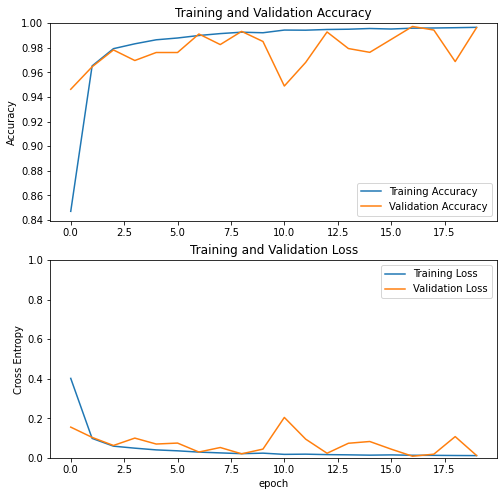

In [10]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [11]:
# unlock_at = 175
# unlock_at = 100
# for layer in base_model.layers[:unlock_at]:layer.trainable = False     # Freeze all the layers before the `unlock_at` layer
# for layer in base_model.layers[unlock_at:]:layer.trainable = True
learning_rate = base_learning_rate/10   # Lowering learning rate to 10% to prevent overfit
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 random_rotation (RandomRota  (None, 224, 224, 3)      0         
 tion)                                                           
                                                                 
 random_translation (RandomT  (None, 224, 224, 3)      0         
 ranslation)                                                     
                                                                 
 random_flip (RandomFlip)    (None, 224, 224, 3)       0         
                                                                 
 random_contrast (RandomCont  (None, 224, 224, 3)      0         
 rast)                                                           
                                                             

In [12]:
len(model.trainable_variables)

158

In [13]:
fine_tune_epochs = 20
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_set,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=val_set)

Epoch 20/40
578/578 [==============================] - 429s 742ms/step - loss: 0.0109 - accuracy: 0.9964 - val_loss: 0.0445 - val_accuracy: 0.9856
Epoch 21/40
578/578 [==============================] - 441s 762ms/step - loss: 0.0106 - accuracy: 0.9966 - val_loss: 0.0232 - val_accuracy: 0.9933
Epoch 22/40
578/578 [==============================] - 443s 764ms/step - loss: 0.0098 - accuracy: 0.9969 - val_loss: 0.0105 - val_accuracy: 0.9965
Epoch 23/40
578/578 [==============================] - 442s 764ms/step - loss: 0.0075 - accuracy: 0.9975 - val_loss: 0.0119 - val_accuracy: 0.9962
Epoch 24/40
578/578 [==============================] - 442s 764ms/step - loss: 0.0093 - accuracy: 0.9969 - val_loss: 0.0194 - val_accuracy: 0.9934
Epoch 25/40
578/578 [==============================] - 443s 765ms/step - loss: 0.0087 - accuracy: 0.9972 - val_loss: 0.0196 - val_accuracy: 0.9947
Epoch 26/40
578/578 [==============================] - 442s 763ms/step - loss: 0.0085 - accuracy: 0.9971 - val_loss: 0

In [14]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

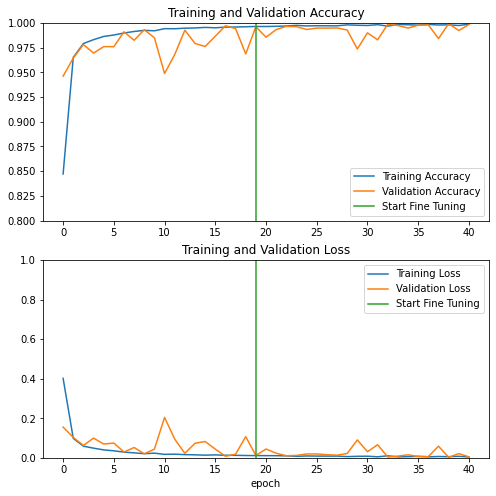

In [15]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [16]:
loss, accuracy = model.evaluate(test_set)
print('Test accuracy :', accuracy)

82/82 [==============================] - 38s 387ms/step - loss: 0.0060 - accuracy: 0.9978
Test accuracy : 0.9978086948394775


In [17]:
# Save checkpoint
checkpoint_path = "/media/teera/SSD250GB/model/classification/chess/MobileNetV2_color/cp-{epoch:04d}.ckpt"
model.save_weights(checkpoint_path.format(epoch=20))

In [18]:
model.save('/media/teera/SSD250GB/model/classification/chess/MobileNetV2_color/model.h5')

In [19]:
savedModel = tf.keras.models.load_model('/media/teera/SSD250GB/model/classification/chess/MobileNetV2_color/model.h5')
savedModel.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 random_rotation (RandomRota  (None, 224, 224, 3)      0         
 tion)                                                           
                                                                 
 random_translation (RandomT  (None, 224, 224, 3)      0         
 ranslation)                                                     
                                                                 
 random_flip (RandomFlip)    (None, 224, 224, 3)       0         
                                                                 
 random_contrast (RandomCont  (None, 224, 224, 3)      0         
 rast)                                                           
                                                             